In [1]:
import gensim.downloader as api
from gensim.models import FastText
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE, trustworthiness
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
import pandas as pd

In [2]:
%run ../database.ipynb

In [3]:
pretrained_model = api.load("word2vec-google-news-300")

df = pd.DataFrame(get_all_content())

corpus = df["preprocessed_token"]
y = df["siebert_sentiment_score"]

In [4]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Detected {num_cores} cores")

model = FastText(
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    workers=num_cores - 1,
    batch_words=15000
)

model.build_vocab(corpus)
total_examples = model.corpus_count

model.build_vocab([list(pretrained_model.key_to_index.keys())], update=True)
model.train(corpus, total_examples=total_examples, epochs=20)

Detected 20 cores


(27946034, 40327420)

<h1>t-SNE Visualization 2D<h1>

In [5]:
words = list(model.wv.index_to_key)[:100000]
word_vectors = model.wv[words]

In [6]:
pca = PCA(n_components=30, random_state=42)
word_vectors_pca = pca.fit_transform(word_vectors)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"PCA Explained Variance: {explained_variance:.4f}")

tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=10000)
word_vecs_2d = tsne.fit_transform(word_vectors_pca)

print(f"Final KL Divergence: {tsne.kl_divergence_:.4f}")

trust_score = trustworthiness(word_vectors_pca, word_vecs_2d, n_neighbors=5)
print(f"Trustworthiness Score: {trust_score:.4f}")

high_d_distances = pdist(word_vectors_pca, metric="euclidean")
low_d_distances = pdist(word_vecs_2d, metric="euclidean")

correlation, _ = spearmanr(high_d_distances, low_d_distances)
print(f"Spearman Correlation for Distance Preservation: {correlation:.4f}")

PCA Explained Variance: 0.4630


c:\Users\wwwhh\OneDrive\Desktop\fyp backend\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Final KL Divergence: 2.7867
Trustworthiness Score: 0.9815
Spearman Correlation for Distance Preservation: 0.6856


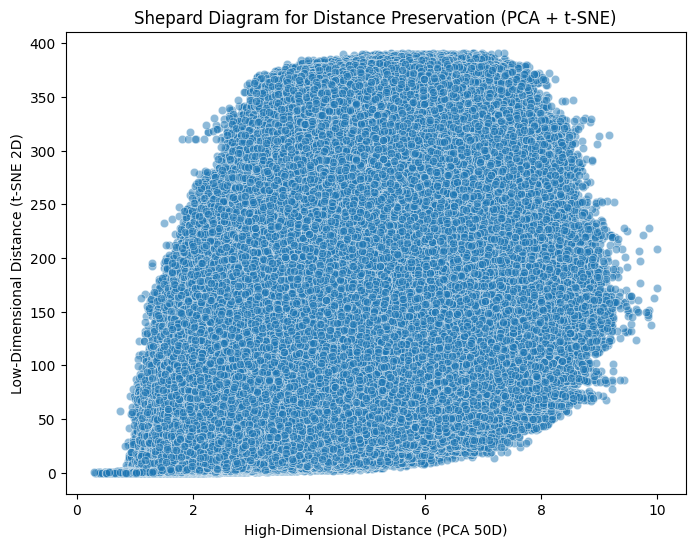

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=high_d_distances, y=low_d_distances, alpha=0.5)
plt.xlabel("High-Dimensional Distance (PCA 50D)")
plt.ylabel("Low-Dimensional Distance (t-SNE 2D)")
plt.title("Shepard Diagram for Distance Preservation (PCA + t-SNE)")
plt.show()

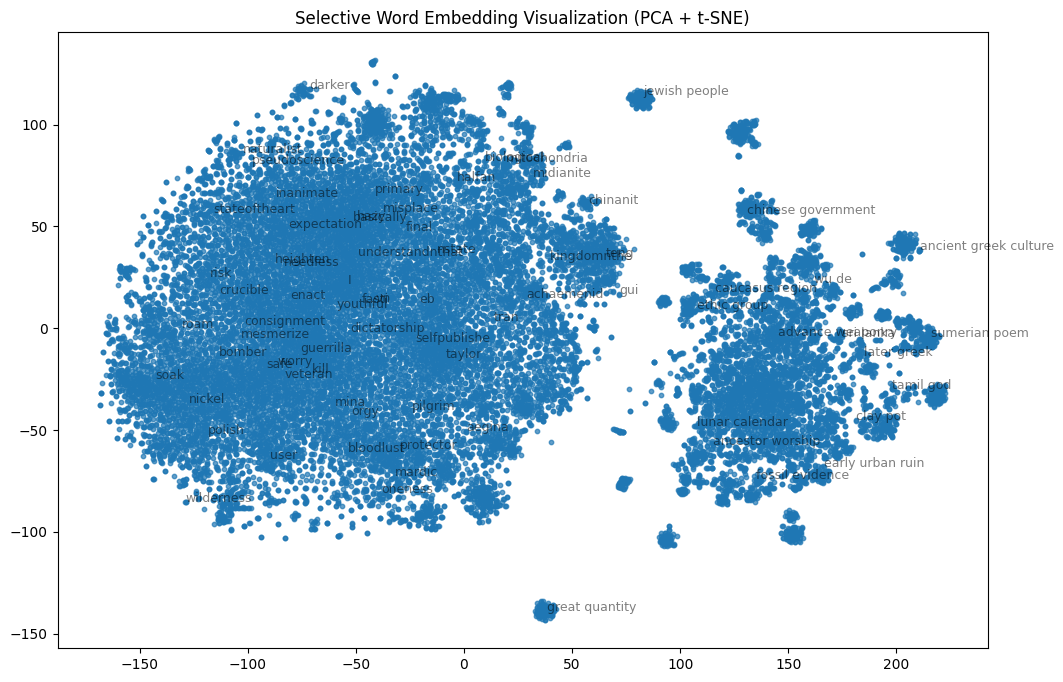

In [8]:
num_labels = 75
indices = np.linspace(0, len(words) - 1, num_labels, dtype=int)

plt.figure(figsize=(12, 8))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], alpha=0.7, s=10)

for i in indices:
    plt.annotate(words[i], (word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=9, alpha=0.5)

plt.title("Selective Word Embedding Visualization (PCA + t-SNE)")
plt.show()